##### 【 KNN기반 Bream_Smelt 식별 모델 】
- 데이터 : 1000개  bream_smelt_best.csv
- 데이터셋
    * 피쳐 : Weight, Length
    * 타겟 : Species
- 학습종류
    * 지도학습 => 분류 : 2진분류
    * 알고리즘 => 최근접이웃 알고리즘 : 거리기반=>스케일링필수. 메모리 고려.

[1] 모듈 로딩 및 데이터 준비<hr>

In [9]:
## 로딩.분석.전처리 모듈
import numpy as np
import pandas as pd

## 시각화 모듈
import matplotlib.pyplot as plt
import koreanize_matplotlib

## ML 모델 / 전처리 모듈
from sklearn.preprocessing import StandardScaler, RobustScaler  # 전처리
from sklearn.model_selection import train_test_split            # 데이터셋 분리
from sklearn.neighbors import KNeighborsClassifier              # 알고리즘

In [2]:
## 데이터 로딩
DATA_FILE = '../Data/bream_smelt_best.csv'

## CSV => DataFrame 로딩
fishDF = pd.read_csv(DATA_FILE)


[2] 데이터 확인 및 전처리<hr>

In [3]:
## [2-1] 데이터 확인 :  info()/describe()/....
display( fishDF.head(3) )
fishDF.info()

,Species,Weight,Length
0,Bream,571.601047,31.859840
1,Bream,738.705906,34.736276
2,Bream,744.045620,35.033417


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  1000 non-null   object 
 1   Weight   1000 non-null   float64
 2   Length   1000 non-null   float64
dtypes: float64(2), object(1)
memory usage: 23.6+ KB


In [ ]:
## 컬럼별 기술통계 확인
## => Weight, Length 모두 음의 왜도. 왼쪽꼬리, 오른쪽 쏠림
fishDF.describe()

,Weight,Length
count,1000.000000,1000.000000
mean,438.688639,26.721465
std,331.322117,10.329141
min,0.001000,7.279967
25%,14.979128,13.388342
50%,508.053365,30.842615
75%,691.673608,34.444984
max,1264.316977,43.363260


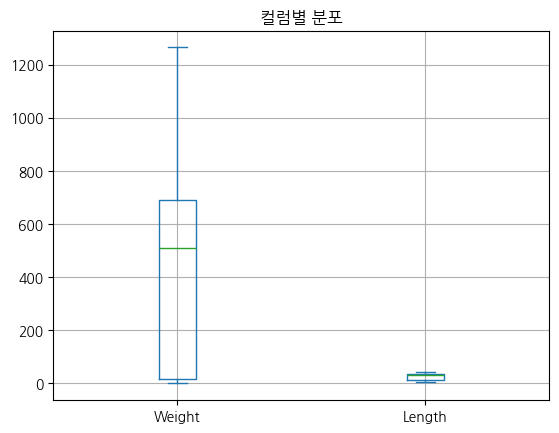

In [ ]:
## -----------------------------------------
## 결측치/중복값/이상치
## -----------------------------------------
fishDF.isna().sum()         ## => 0개

fishDF.duplicated().sum()   ## => 0개

fishDF.plot(kind='box', title='컬럼별 분포', grid=True)
plt.show()

In [8]:
## [2-2] 데이터 타입 :  품종 컬럼 object => category
pd.options.mode.copy_on_write = True

fishDF.Species = fishDF.Species.astype('category')
fishDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Species  1000 non-null   category
 1   Weight   1000 non-null   float64 
 2   Length   1000 non-null   float64 
dtypes: category(1), float64(2)
memory usage: 16.9 KB


[3] 학습관련 전처리 및 준비 <hr>
- 피쳐와 타겟 분리
- 학습용과 테스트용 데이터셋 분리
- 1개의 Data 파일경우 학습용 스케일러 생성 및 학습용/테스트용 적용

In [10]:
## [3-1] 피쳐와 타겟 분리
featureDF = fishDF[fishDF.columns[1:]]
targetSR  = fishDF[fishDF.columns[0]]

print(f'featureDF => {featureDF.shape} / {featureDF.ndim}D')
print(f'targetSR => {targetSR.shape} / {targetSR.ndim}D')

featureDF => (1000, 2) / 2D
targetSR => (1000,) / 1D


In [11]:
## [3-2] 학습용 테스트용 데이터셋 분리 [기: 57:25]
x_train , x_test , y_train, y_test = train_test_split(featureDF,
                                                      targetSR,
                                                      test_size=0.2,
                                                      random_state=7,
                                                      stratify=targetSR)

In [12]:
## 학습용, 테스트용 데이터 개수
print(f'[학습용] {x_train.shape} {x_train.ndim}D, {y_train.shape} {y_train.ndim}D')
print(f'[테스트용] {x_test.shape} {x_test.ndim}D, {y_test.shape} {y_test.ndim}D')

## 2개 라벨/클래스 Bream, Smelt 비율
targetL = (targetSR.value_counts()/targetSR.shape[0]).to_list()
trainL = (y_train.value_counts()/y_train.shape[0]).to_list()
testL = (y_test.value_counts()/y_test.shape[0]).to_list()

print(f'[Target] Bream : Smelt = {targetL[0]:.3f} : {targetL[1]:.3f}')
print(f'[Train]  Bream : Smelt = {trainL[0]:.3f} : {trainL[1]:.3f}')
print(f'[Test]   Bream : Smelt = {testL[0]:.3f} : {testL[1]:.3f}')

[학습용] (800, 2) 2D, (800,) 1D
[테스트용] (200, 2) 2D, (200,) 1D
[Target] Bream : Smelt = 0.700 : 0.300
[Train]  Bream : Smelt = 0.700 : 0.300
[Test]   Bream : Smelt = 0.700 : 0.300


In [15]:
## [3-3] 수치형 피쳐들 스케일 조정 : 스케일러 생성 ★학습용 데이터셋으로 생성
##=> 학습용 데이터셋 기반 스케일러 생성
stdScaler = StandardScaler()
stdScaler.fit(x_train)
print("모델파라미터 :", stdScaler.mean_ , stdScaler.var_, stdScaler.scale_ )

##=> 학습용/테스트용 데이터셋 스케일링 진행 => ★ndarray 타입
s_x_train = stdScaler.transform(x_train)
s_x_test  = stdScaler.transform(x_test)

모델파라미터 : [437.56096204  26.73132569] [1.09559689e+05 1.05485876e+02] [330.99801915  10.27063172]


[4] 학습 진행 => 기준성능 설정 : 학습 모델 기본값 그대로 <hr>

In [41]:
## ---------------------------------------------
## [4-0] 최적의 K값 찾기
## ---------------------------------------------
## 훈련용/테스트용 성능 저장
scoreDict = {'Train':[], 'Test':[]}

## 최근접 이웃수 n_neighbors 범위 : 1 ≤ ~ ≤ √데이터수
MAX_K = 31

## 최적 성능의 k 즉, n_neighbors 찾기
for k  in range(3, MAX_K):
    ##- 모델 인스턴스 생성
    kModel = KNeighborsClassifier(n_neighbors=k)

    ##- 모델 학습 : 학습용 데이터셋
    kModel.fit(s_x_train, y_train)

    ##- 모델 성능평가 : 테스트용 데이터셋
    train_score = kModel.score(s_x_train, y_train)
    test_score = kModel.score(x_test, y_test)

    ##- 학습과 테스트 성능비교 위한 저장
    scoreDict['Train'].append(train_score)
    scoreDict['Test'].append(test_score)

    print(f'[n_neighbors-{k}]  train_score : {train_score:.6f}, test_score : {test_score:.6f}')

[n_neighbors-3]  train_score : 1.000000, test_score : 0.700000
[n_neighbors-4]  train_score : 1.000000, test_score : 0.700000
[n_neighbors-5]  train_score : 1.000000, test_score : 0.700000
[n_neighbors-6]  train_score : 1.000000, test_score : 0.700000
[n_neighbors-7]  train_score : 0.998750, test_score : 0.700000
[n_neighbors-8]  train_score : 0.998750, test_score : 0.700000
[n_neighbors-9]  train_score : 0.998750, test_score : 0.700000
[n_neighbors-10]  train_score : 0.998750, test_score : 0.700000
[n_neighbors-11]  train_score : 0.998750, test_score : 0.700000
[n_neighbors-12]  train_score : 0.998750, test_score : 0.700000
[n_neighbors-13]  train_score : 0.998750, test_score : 0.700000
[n_neighbors-14]  train_score : 0.998750, test_score : 0.700000
[n_neighbors-15]  train_score : 0.998750, test_score : 0.700000
[n_neighbors-16]  train_score : 0.998750, test_score : 0.700000
[n_neighbors-17]  train_score : 0.998750, test_score : 0.700000
[n_neighbors-18]  train_score : 0.998750, test_

c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\KDT\anaconda3\envs\ML\Lib\site-

In [43]:
scores = pd.DataFrame(scoreDict)
scores['diff'] = (scores['Train'] - scores['Test']).abs()
scores.sort_values(by='diff').head()

,Train,Test,diff
7,0.99875,0.7,0.29875
6,0.99875,0.7,0.29875
5,0.99875,0.7,0.29875
4,0.99875,0.7,0.29875
11,0.99875,0.7,0.29875


In [ ]:
## [4-1] 모델 인스턴스 생성
kModel = KNeighborsClassifier()
kModel

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [17]:
## [4-2] 학습 진행 => 학습용 데이터셋만 사용
## .fit(2D_피쳐, 1D_타겟)
kModel.fit(s_x_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


[5] 성능평가 : 테스트용 데이터셋 진행 <hr>
- 학습용, 테스트용 성능 비교

In [18]:
## .score(2D_피쳐, 1D_타겟)
train_score = kModel.score(s_x_train, y_train)
test_score = kModel.score(s_x_test, y_test)

print(f'[성능비교]\n*학습 점수 : {train_score}   *테스트 점수 : {test_score}')

[성능비교]
*학습 점수 : 1.0   *테스트 점수 : 1.0


[6] 일반적인 데이터 예측 서비스 <hr>
- ★★★ 반드시 데이터는 스케일링 후 진행

In [27]:
## 아무 도미 또는 빙어의 길이/무게 ==> 도미와 빙어 예측
in_data = input("생선의 무게, 길이 입력(예:120 23):").strip().split()
in_data = list(map(float, in_data))
print(f'new_data : {in_data}', end=' ')

## DF 형식으로 저장
new_data = pd.DataFrame([in_data] , columns=fishDF.columns[1:])

## 스케일링 진행
s_new_data = stdScaler.transform(new_data)
print(f'=> s_new_data : {s_new_data}')

new_data : [178.0, 29.0] => s_new_data : [[-0.78417678  0.22088946]]


In [28]:
## 예측 진행
pre_target = kModel.predict(s_new_data)

print(f'무게 {in_data[0]}g, 길이 {in_data[1]}mm 생선은 {pre_target.item()}입니다.')

무게 178.0g, 길이 29.0mm 생선은 Bream입니다.


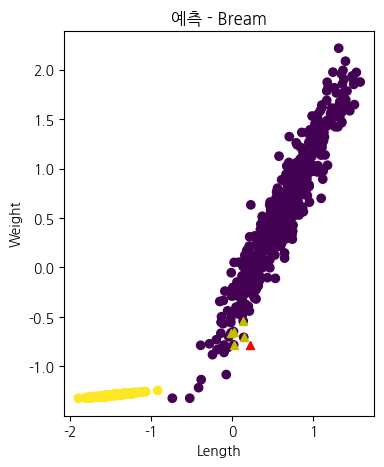

In [32]:
## 예측 검사
_, sIndices = kModel.kneighbors(s_new_data)

## 시각화
plt.figure(figsize=(4, 5))

plt.scatter(s_x_train[:, 1], s_x_train[:, 0], c=y_train.cat.codes)

#-> 새로운 데이터
plt.plot(s_new_data[0][1], s_new_data[0][0], '^r')

#-> 이웃 데이터
nIdx = sIndices[0].tolist()
for idx in nIdx:
    plt.plot(s_x_train[idx][1], s_x_train[idx][0], '^y')

plt.xlabel('Length')
plt.ylabel('Weight')
plt.title(f'예측 - {pre_target.item()}')
plt.show()

[<Axes: > <Axes: >]


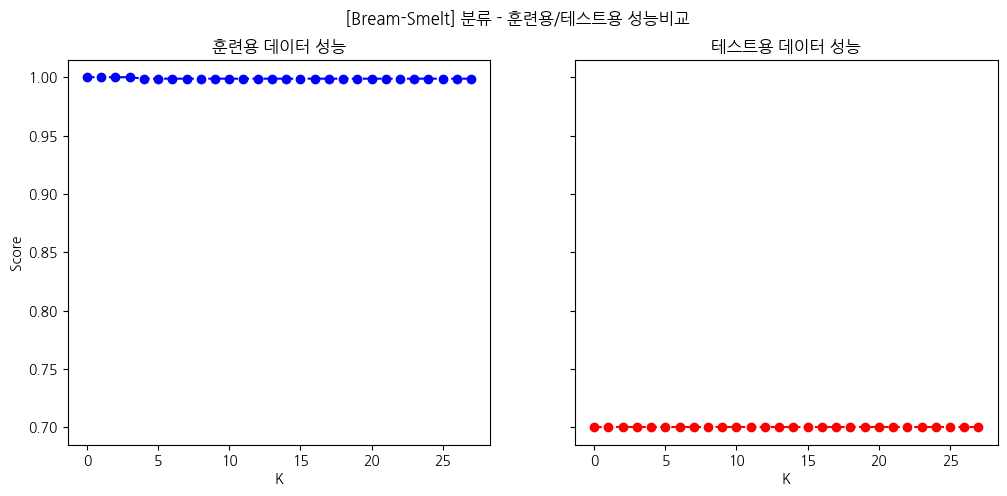

In [45]:
##- k 개수에 따른 학습 및 테스트 성능 시각화
fig, axes = plt.subplots(1,2, sharey=True, figsize=(12, 5))
print(axes)

axes[0].plot(scores['Train'], 'bo--')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Score')
axes[0].set_title("훈련용 데이터 성능")

axes[1].plot(scores['Test'], 'ro--')
axes[1].set_xlabel('K')
axes[1].set_title("테스트용 데이터 성능")

plt.suptitle('[Bream-Smelt] 분류 - 훈련용/테스트용 성능비교')
plt.show()